<a href="https://colab.research.google.com/github/jzphlp/clab/blob/dev-clab/clab_deve_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/DEVDEV/envml"

In [3]:
import os
import glob
import math
import numpy as np
import pandas as pd
import dask.dataframe as dd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from pprint import pprint
import lightgbm as lgb

os.chdir(path)
from params_lgb import *
from df_utils import *

# make this into a function

Parameters: {'device_type': 'cpu', 'num_threads': 2}


In [4]:
max_depth=7
num_leaves = (2 ** max_depth) - 50
num_leaves

78

In [5]:
########################################################################################
# INPUTS
########################################################################################
save_dir = r"zdir"
parquets = r"parquets"
tcolx = 'pdem'
fcolx = ['cdem_dem','edem_dem','egm08','tdem_dem']
interval = 100#500#4500#

modelpath_i1 = os.path.join(save_dir,'model_i1.txt')
modelpath_i1_best = os.path.join(save_dir,'model_i1_best.txt')
np.random.seed(seed=seed)

params = params1


In [7]:
os.makedirs(save_dir, exist_ok=True)
filenames = glob.glob(f'{parquets}/*.parquet'); print(len(filenames))
filenames_shuffled_all = list(shuffle(filenames,random_state=seed))

loops = math.ceil(len(filenames_shuffled_all)/interval)
filenames_shuffled = filenames_shuffled_all[:interval]
train_filenames, val_filenames = train_test_split(
    filenames_shuffled,test_size=0.3, random_state=seed)
out_val = val_filenames


ddf_train = pd.read_parquet(train_filenames)
ddf_valid = pd.read_parquet(val_filenames)

1049


In [8]:
ddf_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cdem_dem  69976 non-null  float32
 1   edem_dem  69976 non-null  float32
 2   egm08     69976 non-null  float32
 3   tdem_dem  69976 non-null  float32
 4   pdem      69976 non-null  float32
dtypes: float32(5)
memory usage: 1.3 MB


In [9]:
ddf_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29986 entries, 0 to 29985
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cdem_dem  29986 non-null  float32
 1   edem_dem  29986 non-null  float32
 2   egm08     29986 non-null  float32
 3   tdem_dem  29986 non-null  float32
 4   pdem      29986 non-null  float32
dtypes: float32(5)
memory usage: 585.8 KB


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def split_data(df, train_size=0.7, valid_size=0.15, test_size=0.15, random_state=None):
    assert train_size + valid_size + test_size == 1, "Train, validation and test sizes must sum to 1"

    # First split: train and temp (valid + test)
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=random_state)

    # Calculate the proportion of validation and test size relative to the temp set
    temp_size = valid_size + test_size
    valid_size_relative = valid_size / temp_size

    # Second split: validation and test
    valid_df, test_df = train_test_split(temp_df, train_size=valid_size_relative, random_state=random_state)

    return train_df, valid_df, test_df

In [19]:
ddf_valid = filter_values(ddf_valid, tcolx, -20, 1000, -9999)

In [20]:
train_df, valid_df, test_df = split_data(ddf_valid.sample(frac=0.5))

In [21]:
train_df.shape

(9445, 5)

In [52]:
def plot_target_across_data_split(tcolx, train_df, valid_df, test_df, i=1):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  len_train = len(train_df)
  len_valid = len(valid_df)
  len_test = len(test_df)
  # Plot histograms on each axis
  axes[0].hist(train_df[tcolx].values, bins=10, color='blue', alpha=0.7)
  axes[0].set_title(f'Train Set {len_train} {i}')
  axes[0].set_xlabel(tcolx)
  axes[0].set_ylabel('Frequency')

  axes[1].hist(valid_df[tcolx].values, bins=10, color='green', alpha=0.7)
  axes[1].set_title(f'Validation Set {len_valid} {i}')
  axes[1].set_xlabel(tcolx)
  axes[1].set_ylabel('Frequency')

  axes[2].hist(test_df[tcolx].values, bins=10, color='red', alpha=0.7)
  axes[2].set_title(f'Test Set {len_test} {i}')
  axes[2].set_xlabel(tcolx)
  axes[2].set_ylabel('Frequency')

  plt.suptitle(str(tcolx).upper())

  # Adjust layout for better spacing
  plt.tight_layout()

  plt.savefig(f'plot_target_across_data_split_{len_train}_{len_valid}_{len_test}_{i}.png')
  return fig

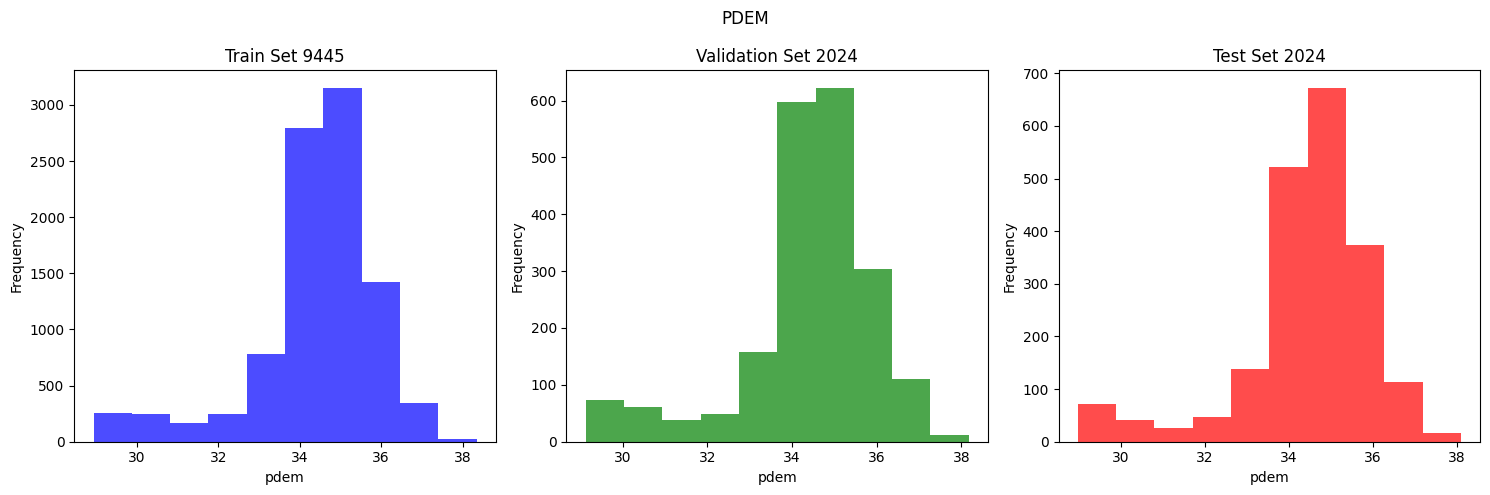

In [30]:
fig1 = plot_target_across_data_split(tcolx, train_df, valid_df, test_df)

In [ ]:
tcolx = 'pdem'
fcolx = ['cdem_dem','edem_dem','egm08','tdem_dem']

In [39]:
features = fcolx
target = tcolx
# Separate features and target
X_train = train_df[features]
y_train = train_df[target]
X_valid = valid_df[features]
y_valid = valid_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Define parameters
params = {
    'objective': 'regression',
    'metric': ['rmse'],
    'verbosity': -1
}

# Train the model with early stopping and verbose_eval set to False
callbacks = [lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
model = lgb.train(params, train_data, valid_sets=[valid_data], callbacks=callbacks)

# Predict on validation and test sets
y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate R2 and RMSE for validation set
valid_r2 = r2_score(y_valid, y_valid_pred)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

# Calculate R2 and RMSE for test set
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f'Validation R2: {valid_r2}')
print(f'Validation RMSE: {valid_rmse}')
print(f'Test R2: {test_r2}')
print(f'Test RMSE: {test_rmse}')

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's rmse: 0.953482
Validation R2: 0.6364233469603946
Validation RMSE: 0.9534818811167757
Test R2: 0.696898732759482
Test RMSE: 0.8539810541421335


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's rmse: 0.933812
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.911963
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.893972
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's rmse: 0.887259
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.89856


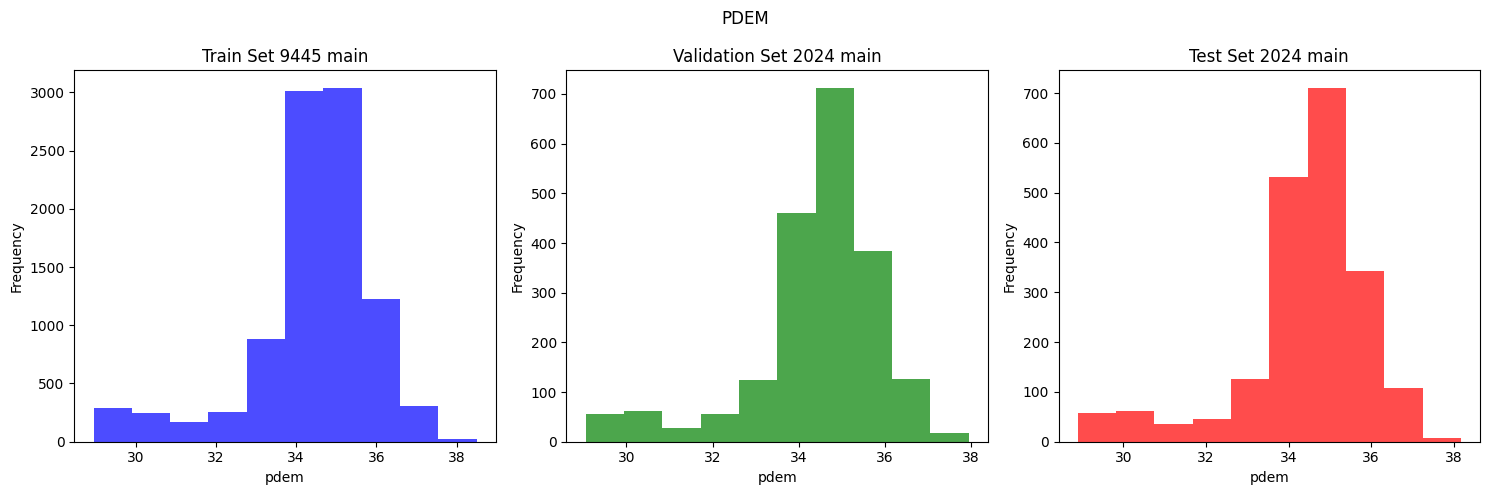

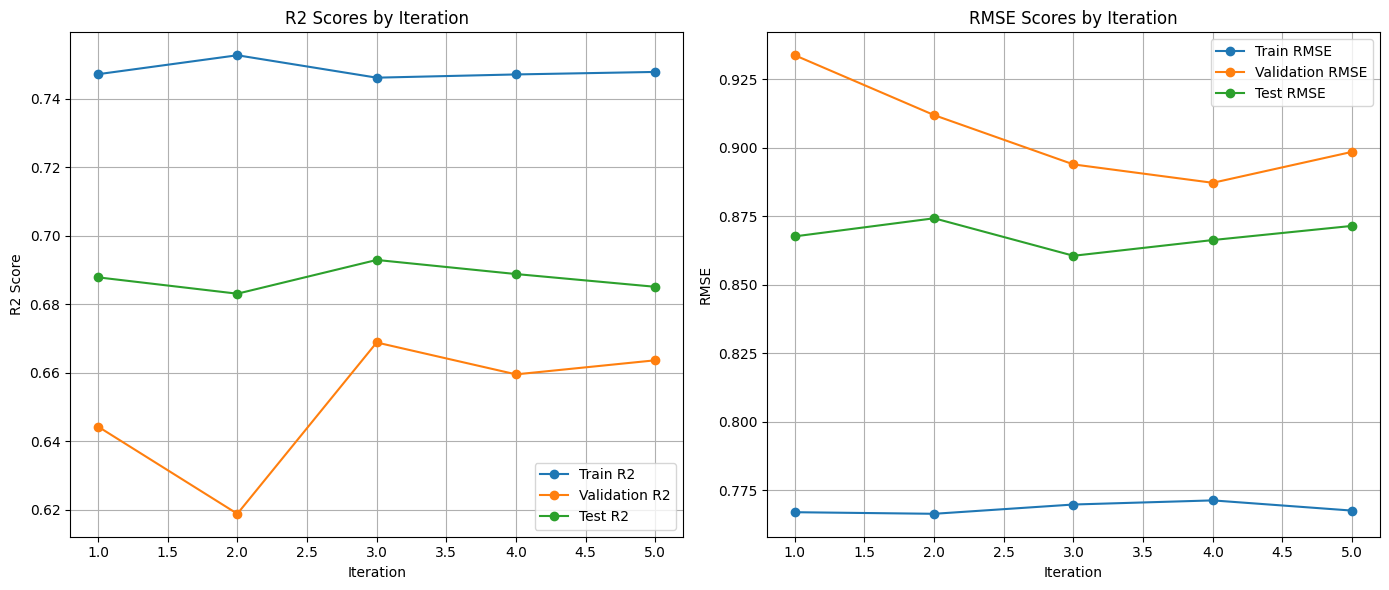

In [60]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

    valid_r2 = r2_score(y_valid, y_valid_pred)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    return {
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Validation R2': valid_r2,
        'Validation RMSE': valid_rmse,
        'Test R2': test_r2,
        'Test RMSE': test_rmse
    }

def split_data(df, train_size=0.7, valid_size=0.15, test_size=0.15, random_state=None):
    assert train_size + valid_size + test_size == 1, "Train, validation and test sizes must sum to 1"
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=random_state)
    temp_size = valid_size + test_size
    valid_size_relative = valid_size / temp_size
    valid_df, test_df = train_test_split(temp_df, train_size=valid_size_relative, random_state=random_state)
    return train_df, valid_df, test_df


def plot_metrics(scores_df):
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))

  # Plot R2 scores
  axes[0].plot(scores_df['Iteration'], scores_df['Train R2'], label='Train R2', marker='o')
  axes[0].plot(scores_df['Iteration'], scores_df['Validation R2'], label='Validation R2', marker='o')
  axes[0].plot(scores_df['Iteration'], scores_df['Test R2'], label='Test R2', marker='o')
  axes[0].set_title('R2 Scores by Iteration')
  axes[0].set_xlabel('Iteration')
  axes[0].set_ylabel('R2 Score')
  axes[0].legend()
  axes[0].grid(True)

  # Plot RMSE scores
  axes[1].plot(scores_df['Iteration'], scores_df['Train RMSE'], label='Train RMSE', marker='o')
  axes[1].plot(scores_df['Iteration'], scores_df['Validation RMSE'], label='Validation RMSE', marker='o')
  axes[1].plot(scores_df['Iteration'], scores_df['Test RMSE'], label='Test RMSE', marker='o')
  axes[1].set_title('RMSE Scores by Iteration')
  axes[1].set_xlabel('Iteration')
  axes[1].set_ylabel('RMSE')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()
  return fig

train_df, valid_df, test_df = split_data(ddf_valid.sample(frac=0.5), train_size=0.7,
                                         valid_size=0.15, test_size=0.15, random_state=42)
n_iterations = 5
all_scores = []
X_test = test_df[features]
y_test = test_df[target]

figx = plot_target_across_data_split(tcolx, train_df, valid_df, test_df, i='main') #try kfold types
for i in range(n_iterations):
    # Combine train and validation data, shuffle and split again
    combined_df = pd.concat([train_df, valid_df])
    combined_df = shuffle(combined_df, random_state=42 + i)
    train_df, valid_df = train_test_split(combined_df, test_size=0.15, random_state=42 + i)

    # Separate features and target
    X_train = train_df[features]
    y_train = train_df[target]
    X_valid = valid_df[features]
    y_valid = valid_df[target]
    #plot_target_across_data_split(tcolx, train_df, valid_df, test_df, i=f'iter{i}')
    #X_test = test_df[features]
    #y_test = test_df[target]

    # Create LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # Train the model with early stopping
    callbacks = [lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
    model = lgb.train(params, train_data, valid_sets=[valid_data], callbacks=callbacks)

    # Evaluate and collect scores
    scores = evaluate_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test)
    scores['Iteration'] = i + 1
    all_scores.append(scores)

# Convert scores to DataFrame
scores_df = pd.DataFrame(all_scores)
fig_metrics = plot_metrics(scores_df)

In [55]:
scores_df

,Train R2,Train RMSE,Validation R2,Validation RMSE,Test R2,Test RMSE,Iteration
0,0.752962,0.763774,0.704883,0.830474,0.696940,0.871254,1
1,0.749671,0.763084,0.708421,0.860035,0.702412,0.863353,2
2,0.749630,0.763633,0.696483,0.874561,0.704168,0.860803,3
3,0.754768,0.759838,0.661966,0.896252,0.697690,0.870176,4
4,0.754864,0.767665,0.632727,0.877032,0.705028,0.859551,5


In [ ]:
########################################################################################
# MODELLING
########################################################################################
os.makedirs(save_dir, exist_ok=True)
filenames = glob.glob(f'{parquets}/*.parquet'); print(len(filenames))
filenames_shuffled_all = list(shuffle(filenames,random_state=seed))

loops = math.ceil(len(filenames_shuffled_all)/interval)
filenames_shuffled = filenames_shuffled_all[:interval]
train_filenames, val_filenames = train_test_split(
    filenames_shuffled,test_size=0.3, random_state=seed)
out_val = val_filenames


ddf_train = pd.read_parquet(train_filenames)
ddf_train = filter_values(ddf_train, tcolx, -20, 1000, -9999)
xtrain, ytrain = ddf_train.drop(tcolx, axis=1), ddf_train[tcolx]
del ddf_train

ddf_valid = pd.read_parquet(val_filenames)
ddf_valid = filter_values(ddf_valid, tcolx, -20, 1000, -9999)
xvalid, yvalid = ddf_valid.drop(tcolx, axis=1), ddf_valid[tcolx]
del ddf_valid
 # is there a way of spling x,y without having to load the data and then delete
train_ds = lgb.Dataset(data=xtrain,label=ytrain,feature_name=fcolx)
valid_ds = lgb.Dataset(data=xvalid,label=yvalid,feature_name=fcolx)

gbm = lgb.train(params,
                train_ds,
                num_round,
                valid_sets=valid_ds,
                feval=mean_error,
                keep_training_booster=True, # lear what it does
                callbacks=[lgb.early_stopping(stopping_rounds=50)])

gbm.save_model(modelpath_i1)
gbm.save_model(modelpath_i1_best,num_iteration=gbm.best_iteration)


pvalid = gbm.predict(xvalid)
derror = Rmetrics(yvalid, pvalid)
derror.to_csv(os.path.join(save_dir,'metrics_i1.csv'), index=False)
pprint(derror)

booster = None
for i in range(1,loops):
    print(f'Icrementtal at looop {i}/{loops}')
    start_index = interval*i
    if i == loops - 1:
        end_index = len(filenames_shuffled_all) - 1
    else:
        end_index = interval*i+interval
    filenames_shuffled = filenames_shuffled_all[start_index:end_index]
    train_filenames, val_filenames = train_test_split(
        filenames_shuffled,test_size=0.3, random_state=seed)
    out_val = np.append(out_val,val_filenames)

    ddf_train = pd.read_parquet(train_filenames)
    ddf_train = filter_values(ddf_train, tcolx, -20, 1000, -9999)
    xtrain, ytrain = ddf_train.drop(tcolx, axis=1), ddf_train[tcolx]
    del ddf_train

    ddf_valid = pd.read_parquet(val_filenames)
    ddf_valid = filter_values(ddf_valid, tcolx, -20, 1000, -9999)
    xvalid, yvalid = ddf_valid.drop(tcolx, axis=1), ddf_valid[tcolx]
    del ddf_valid

    # is there a way of spling x,y without having to load the data and then delete
    train_ds = lgb.Dataset(data=xtrain,label=ytrain,feature_name=fcolx)
    valid_ds = lgb.Dataset(data=xvalid,label=yvalid,feature_name=fcolx)

    keep_training_booster_val = True
    booster = None

   # print(f'INTITIAL############')
    initial_scores = gbm.predict(xtrain) #####INITIAL SCORES
    #derror = Rmetrics(ytrain, initial_scores)
    #pprint(derror)
    #gbm.add_valid(train_ds, initial_scores)
    #gbm.continue_training(init_scores=initial_scores)
    train_ds.set_init_score(initial_scores)
    gbm = lgb.train(params,
                train_ds,
                num_round,
                valid_sets=valid_ds,
                feval=mean_error,
                #init_model=booster,
                keep_training_booster=True, # lear what it does
                init_model=gbm,
                callbacks=[lgb.early_stopping(stopping_rounds=50)],
                )

    gbm.save_model(modelpath_i1)
    gbm.save_model(modelpath_i1_best,num_iteration=gbm.best_iteration)

out_val_pd = pd.DataFrame(out_val,columns=['files'])
out_val_pd.to_csv(os.path.join(save_dir,'validation_files.csv'),index=None)

pvalid = gbm.predict(xvalid)
derrorf = Rmetrics(yvalid, pvalid)
derrorf.to_csv(os.path.join(save_dir,'metrics_f1.csv'), index=False)
pprint(derror)
pprint(derrorf)


1049
Training until validation scores don't improve for 50 rounds
         R2      RSME       MAE  MedianAE      Bias
0  0.596488  0.977744  0.703963  0.529808  0.126865
Icrementtal at looop 1/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 2/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 3/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 4/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 5/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 6/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 7/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 8/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 9/11
Training until validation scores don't improve for 50 rounds
Icrementtal at looop 10/11
Training until valid

In [ ]:
# now its more like it

##### Assume you already have your existing model and data
existing_model = lgb.Booster(model_file='existing_model.txt')
new_data = np.random.rand(100, 10)  # Example new data, replace with your actual new data

##### Assume you have initial scores for the new data
initial_scores = np.random.rand(100)

##### Perform continued training with the new data and initial scores
existing_model.add_valid(new_data, initial_scores)
existing_model.continue_training(init_scores=initial_scores)

##### Save the updated model
existing_model.save_model('updated_model.txt')

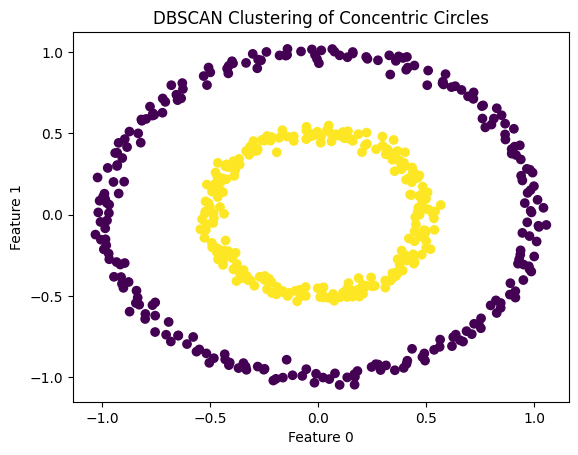

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.cluster import DBSCAN, KMeans
import numpy as np

# Create a concentric circle dataset
X, _ = make_circles(n_samples=500, factor=.5, noise=.03, random_state=4)

# Apply DBSCAN to the dataset
dbscan = DBSCAN(eps=0.1, min_samples=5)
clusters = dbscan.fit_predict(X)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title("DBSCAN Clustering of Concentric Circles")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


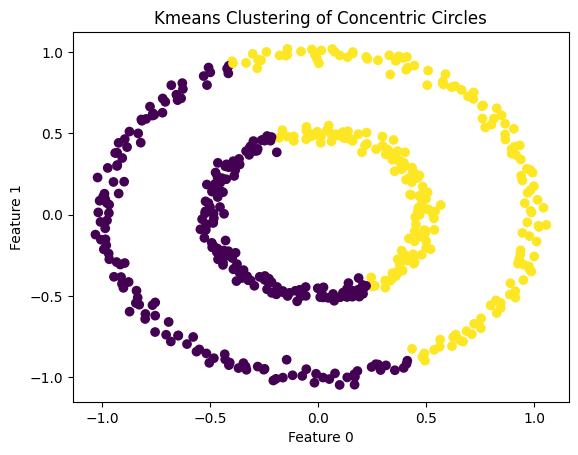

In [ ]:
# # Apply DBSCAN to the dataset
kmeams = KMeans(2)
clusters = kmeams.fit_predict(X)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title("Kmeans Clustering of Concentric Circles")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

In [ ]:
# dbscan appear to be better
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
# do Kmeans, DBscan and one more in pytorch to use GPU